# School Safety - Part 1
### *Data Preparation and Violence Regression*

## 1. Background
The US government makes many datasets publically available, and I had a particular interest in school safety. While the media often highlights tragic cases of gun violence, I wanted to dig deeper and see if there was anything to be learned about crime and safety in general at schools. Forunately, the Department of Education conducts a periodic survey of public schools in the country: The School Survey on Crime and Safety (SSOCS). More information on this survey can be found [here](https://nces.ed.gov/surveys/ssocs/index.asp?FType=3). For this project, I downloaded cross-sectional data from the 2015-2016 school year. The relevant files are available directly in my GitHub repository, although they can also be manually downloaded from the National Center for Education Statistics (NCES) [website](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2018109). After some preliminary analysis, I chose to focus on three main questions:

1. Is it possible to predict how many violent incidents a school will have in a given year?
2. Is it possible to predict the extent to which bullying occurs at a school?
3. Is there discrimination based on race when it comes to disciplinary action at schools?

This notebook will focus on cleaning/exploring the data and developing insights for the first question above. 

**The analysis resulted in the following conclusions:**
1. OLS with RFE was the best model.
2. Drug testing, required faculty ID, teacher training on substance abuse, and community involvement in school safety were all associated with a reduction in violent incidents. 
3. Larger schools were associated with more violent incidents. 
4. Metal detectors, required student IDs, required clear book bags/book bag bans, and presence of law enforcement were associated with an increase in violent incidents (correlation does not imply causation).

## 2. Setup/Data Cleaning

The following [module](https://pypi.org/project/sas7bdat/) needs to be installed in order to read the original data file:

```pip install sas7bdat```


In [435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sas7bdat import SAS7BDAT

%matplotlib inline

pd.options.display.max_columns = 17

In [436]:
#Load the full data file into a dataframe
reader = SAS7BDAT('school_safety.sas7bdat', skip_header=False)
school_df = reader.to_data_frame()

#Load the target variable of interest into a series
#VIOINC16 = Total number of violent incidents recorded
y_regression = school_df["VIOINC16"]

Given that I was running a regression on total number of violent incidents at schools, I suspected that the target variable would contain many outliers. My first step was to visualize the data and remove any outliers that would prove troublesome for machine learning algorithms

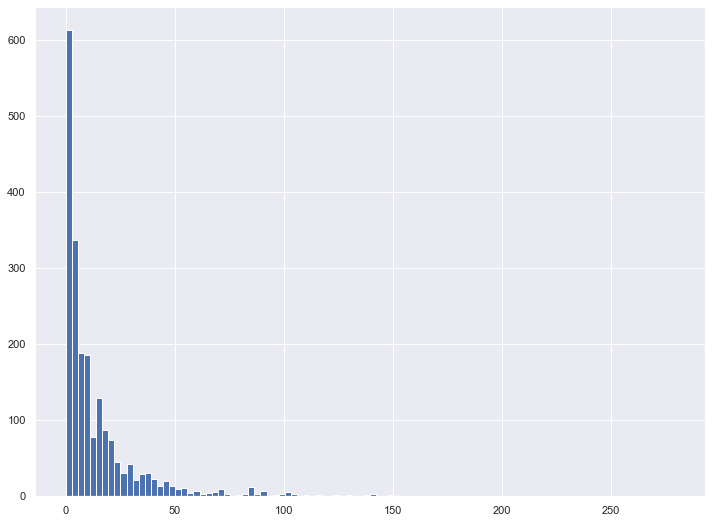

In [437]:
y_regression.hist(bins=100, figsize=(12,9))

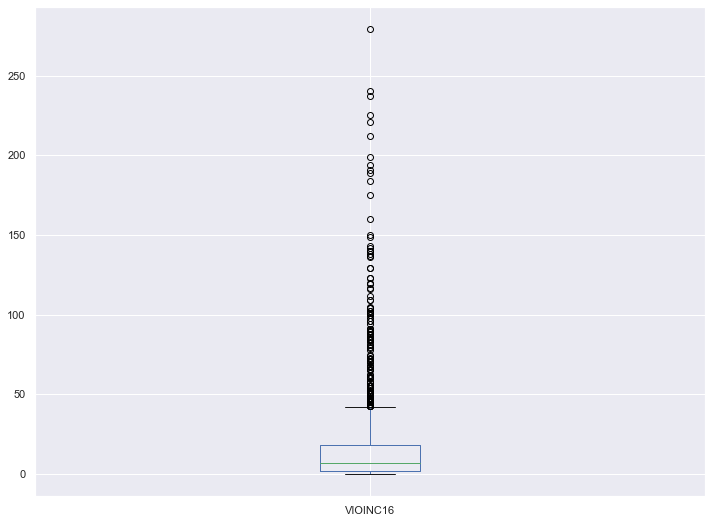

In [438]:
y_regression.plot.box(figsize=(12,9))

In [439]:
from scipy.stats import iqr

#An observation is considered an outlier if it lies more than 1.5 * IQR from the median
upper_bound = y_regression.median() + 1.5 * iqr(y_regression)
lower_bound = y_regression.median() - 1.5 * iqr(y_regression)
print("Upper Bound: " + str(upper_bound))
print("Lower Bound: " + str(lower_bound))

Upper Bound: 31.0
Lower Bound: -17.0


In [440]:
print("Number of Target Points: " + str(len(y_regression)))
print("Number of Outliers: " + str(sum(y_regression > upper_bound)))
print("Proportion Outliers: " + str(sum(y_regression > upper_bound)/len(y_regression)))

Number of Target Points: 2092
Number of Outliers: 278
Proportion Outliers: 0.13288718929254303


Eliminating all 278 outliers unfortunately reduced my dataset by more than 10%, which isn't ideal given I didn't have an abundance of schools to start with. However, after running this analysis with different upper bound cutoffs, I decided it made sense to limit the data set to schools with 31 or fewer violent incidents.

In [441]:
y_regression_reduced = y_regression[y_regression <= 31]

Next, it was time to develop a dataframe of features. I removed any rows corresponding to outliers as calculated above.

In [442]:
school_df_reduced = school_df.iloc[y_regression_reduced.index, :]
school_df_reduced

,SCHID,C0014_R,C0016_R,C0110,C0112,C0114,C0116,C0120,...,IC0538,IC0560,IC0562,IC0568,IC0570,IC0572,IC0578,IC0580
0,1.0,1.0,5.0,1.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,2.0,8.0,2.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,7.0,0.0,0.0,0.0,7.0,7.0,0.0,0.0
3,4.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.0,1.0,-2.0,1.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,3546.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2088,3547.0,1.0,3.0,1.0,1.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2089,3548.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2090,3552.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


At a first glance, I noticed that there are a lot of columns in this dataset. To address this issue, I manually went through the column description list (**column_descriptions.docx** in this repository) and saved information for each column in **column_filter.csv**. Each row contains the following info:
1. **Variable**: Coded representation of the survey question
2. **Label**: Description of the survey question
3. **Format**: Whether the answer is numerical or not
4. **Target**: A value of 1 means the survey question is a target variable for predictions (these will not be used as features for any analysis)
5. **Drop**: A value of 1 means that the variable is not useful in this project and will be dropped (I have chose to drop any qualitative (opinion-based) questions or irrelevant questions)
6. **Binary**: A value of 1 means that the variable takes on Y/N values
7. **Dummy**: A value of 1 means that the variable is categorical but not in Y/N format (these will need to be expanded into dummy representations)

Below, I selected relevant feature columns for my analysis

In [443]:
cols_to_keep_df = pd.read_csv("column_filter.csv")
cols_to_keep_df.head()

,Variable,Label,Format,Target,Drop,Binary,Dummy,Dummy_Dic
0,SCHID,Unique school identifier,Num,NaN,1.0,NaN,NaN,NaN
1,C0014_R,Title/position of respondent (recoded),Num,NaN,1.0,NaN,NaN,NaN
2,C0016_R,# of years respondent at the school (topcoded),Num,NaN,1.0,NaN,NaN,NaN
3,C0110,School practice require visitor check in and b...,Num,NaN,NaN,1.0,NaN,NaN
4,C0112,Building access controlled locked/monitored doors,Num,NaN,NaN,1.0,NaN,NaN


In [446]:
#Remove any qualitative (opinion-based) questions, irrelevant questions or target variables
cols_to_keep_df = cols_to_keep_df[(cols_to_keep_df["Drop"] != 1) & (cols_to_keep_df["Target"] != 1)]

#Use the above df to filter the full school_df
feature_df = school_df_reduced[cols_to_keep_df["Variable"]]
feature_df.head()

,C0110,C0112,C0114,C0116,C0120,C0121,C0122,C0124,...,C0538,C0568,SEC_FT16,SEC_PT16,FR_URBAN,FR_LVEL,FR_SIZE,PERCWHT
0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,...,6.0,94.0,0.0,0.0,4.0,1,2.0,2
1,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,...,6.0,95.0,0.0,0.0,4.0,1,2.0,4
2,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,...,6.0,95.0,0.0,1.0,4.0,1,2.0,3
3,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,...,2.0,96.0,0.0,0.0,4.0,1,2.0,4
4,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,...,5.0,85.0,1.0,0.0,4.0,1,2.0,4


Next, I created a function to map the full survey question to the coded representation. This will prove handy later on when analyzing model results.

In [447]:
def col_description_lookup(col_list):
    result = pd.DataFrame({"Variable" : col_list})
    result = result.merge(cols_to_keep_df[["Variable", "Label"]], how="left", on="Variable")
    return result

Next, I cleaned the remaining feature columns.

C:\Users\Sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Sahil\anaconda3\lib\site-packages\pandas\core\frame.py:3089: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


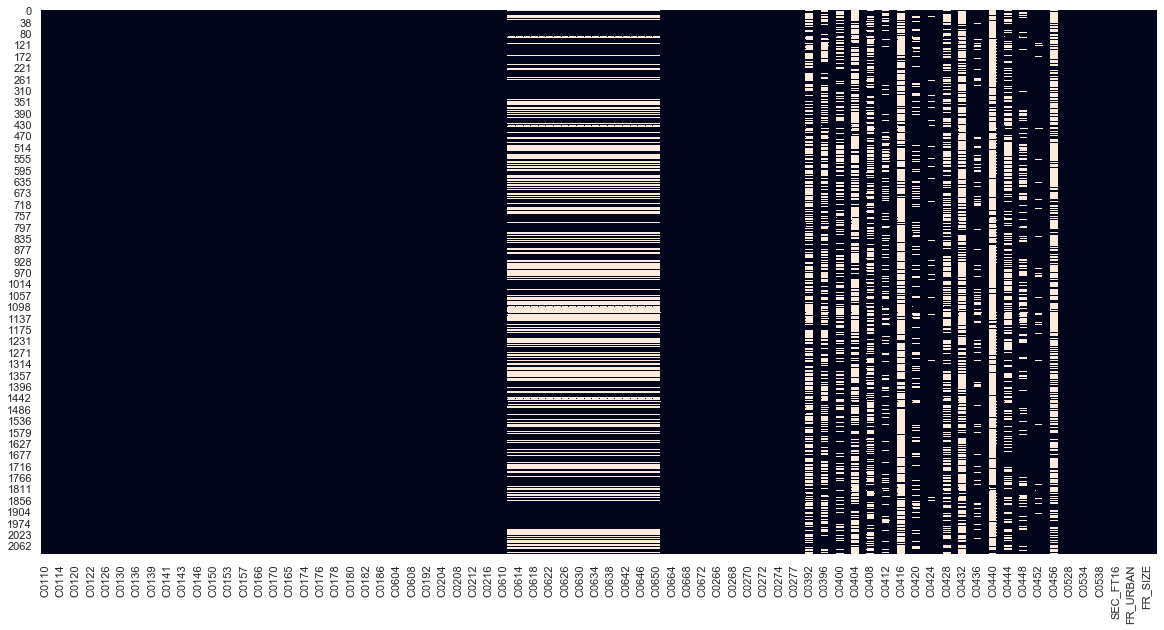

In [448]:
#A value of -1 represents a missing value. Convert -1 to np.nan
feature_df[feature_df == -1] = np.nan

#Create a heatmap to visualize missing values
fig, ax = plt.subplots(figsize=(20,10))  
sns.heatmap(feature_df.isnull(), cbar=False, ax=ax)

In the above heatmap, white cells represent missing values. I noticed that the majority of columns have no missing values. Those that do have missing values tend to have a lot. Given that I had an abundance of feature columns, I wanted to check if it would be safe to just drop these missing value columns rather than come up with a messy imputation.

In [451]:
#Create a list of missing value columns
nan_cols = [col for col in feature_df.columns if feature_df[col].isnull().any()]

#Create a dataframe to see the corresponding questions
with pd.option_context('display.max_colwidth', 150, 'display.max_rows', 10):
    display(col_description_lookup(nan_cols))

,Variable,Label
0,C0612,Sworn law enforcement officers present during school
1,C0614,Sworn law enforcement officers while students arriving or leaving
2,C0616,Sworn law enforcement officers present at school activities
3,C0618,Sworn law enforcement officers present at other times
4,C0620,Sworn law enforcement officers with stun gun
...,...,...
32,C0440,Corporal punishment available - action used
33,C0444,School probation available - action used
34,C0448,Detention/Saturday school available - action used
35,C0452,Loss of student privileges available - action used


After some thought, I decided it would be best to just drop the above columns given that I had to reduce the dimensionality of my data and other questions are quite correlated with the above.

In [452]:
#Drop any columns with missing values
feature_df = feature_df.dropna(axis = 1)

I noticed that Y/N answers were encoded as Y=1 and N=2. I chose to reencode them as Y=1 and N=0. For categorical variables with more than 2 answer choices, I created mapping to custom values, as explained below. I chose to map most of these variables into binary buckets to keep data dimensionality in check. The one exception is the **PERCWHT** column which I split into 4 numerical values based on the middle value of the answer bucket (see survey PDF for more details).

In [453]:
#Select binary columns
binary_cols = [col for col in feature_df.columns if feature_df[col].isin([1,2]).all()]

#Select non-binary columns
non_binary_cols = [col for col in feature_df.columns if not feature_df[col].isin([1,2]).all()]

In [454]:
#Convert non-binary categorical columns to custom values

#1 if city else 0
feature_df["FR_URBAN"] = feature_df["FR_URBAN"].apply(lambda x: 1 if x==1 else 0)
#1 if high school else 0
feature_df["FR_LVEL"] = feature_df["FR_LVEL"].apply(lambda x: 1 if x==3 else 0)
#1 if >=500 students else 0
feature_df["FR_SIZE"] = feature_df["FR_SIZE"].apply(lambda x: 1 if x in [3,4] else 0)
#Convert categorical to numerical based on middle of answer bucket
feature_df["PERCWHT"] = feature_df["PERCWHT"].map({"1":97.5, "2":87.5, "3":65, "4":25})

In [455]:
#Convert Y/N columns to 0 or 1
feature_df[binary_cols] = feature_df[binary_cols].applymap(lambda x: 1 if x==1 else 0)

In [456]:
#Recalculate binary vs non-binary columns
binary_cols = [col for col in feature_df.columns if feature_df[col].isin([0,1]).all()]
non_binary_cols = [col for col in feature_df.columns if not feature_df[col].isin([0,1]).all()]

After this data cleaning, I was still left with 109 features. Also, many of these features seemed to be redundant/correlated. Multicollinearity would make interpretation of regression models difficult so I utilized the variance inflation factor (VIF) calculation to remove highly correlated variables. I recursively eliminated the variable with the highest VIF until all remaining variables had a VIF below 5, which is the threshold commonly used in statistical literature. Given the large amount of starting columns, the below code took a while to run.

In [373]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VIF_reduce(df, threshold = 5):
    cols_to_keep = list(df.columns)
    reduced_df = df[cols_to_keep]
    
    vif = [variance_inflation_factor(reduced_df.values, i) for i in range(reduced_df.shape[1])]
    
    while max(vif) >= threshold:
        col_to_remove = vif.index(max(vif))
        
        print(cols_to_keep.pop(col_to_remove) + " has been removed: VIF = " +str(max(vif)))
        
        reduced_df = df[cols_to_keep]
        
        vif = [variance_inflation_factor(reduced_df.values, i) for i in range(reduced_df.shape[1])]
        
    return df[cols_to_keep]

In [374]:
feature_df = VIF_reduce(feature_df, threshold = 5)

C:\Users\Sahil\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


C0568 has been removed: VIF = 88.9481242421213
C0166 has been removed: VIF = 32.22691216002344
C0536 has been removed: VIF = 26.061813584493297
C0422 has been removed: VIF = 24.584240321765776
C0165 has been removed: VIF = 23.891070796283433
C0110 has been removed: VIF = 23.08214771193544
C0178 has been removed: VIF = 22.657129716558288
C0450 has been removed: VIF = 21.448341547201
C0270 has been removed: VIF = 21.261035333947035
C0155 has been removed: VIF = 19.66587603327097
C0181 has been removed: VIF = 16.39117346128267
C0176 has been removed: VIF = 16.10975461100661
C0112 has been removed: VIF = 14.389599854850395
C0163 has been removed: VIF = 12.90990126925419
C0174 has been removed: VIF = 12.10344649790163
C0267 has been removed: VIF = 11.898402641419715
C0534 has been removed: VIF = 10.51074290671067
C0169 has been removed: VIF = 10.382580398174706
C0182 has been removed: VIF = 10.242257784182929
C0538 has been removed: VIF = 9.881638419897971
PERCWHT has been removed: VIF = 9.

In [459]:
#I exported the final feature dataframe to a CSV file for easy access. File available in this repository.
feature_df = pd.read_csv("feature_df_regression.csv",index_col=0)
feature_df.head()

,C0114,C0116,C0120,C0121,C0122,C0124,C0126,C0128,...,C0526,C0528,C0532,SEC_FT16,SEC_PT16,FR_URBAN,FR_LVEL,FR_SIZE
0,1,0,0,0,0,0,0,0,...,2.0,17.0,30.0,0.0,0.0,0,0,0
1,1,0,0,1,1,0,0,0,...,25.0,2.0,0.0,0.0,0.0,0,0,0
2,1,0,0,1,1,0,0,0,...,5.0,9.0,18.0,0.0,1.0,0,0,0
3,1,0,0,0,1,0,0,0,...,61.0,9.0,15.0,0.0,0.0,0,0,0
4,1,0,0,1,1,0,0,0,...,35.0,8.0,40.0,1.0,0.0,0,0,0


In [460]:
#Recalculate binary and non-binary columns based on the VIF reduced feature df
binary_cols = [col for col in feature_df.columns if feature_df[col].isin([0,1]).all()]
non_binary_cols = [col for col in feature_df.columns if not feature_df[col].isin([0,1]).all()]

After the VIF reduction, I was left with 74 feature variables. While still higher than I would have ideally liked, I chose to continue with the analysis and address feature selection as necessary in the following models.

## 3. Predictive Modeling
In this section, I trained several different machine learning models to see if the features from section 2 above could be used to make predictions about how many incidents of violence would occur at a US public school. I chose root mean square error (RMSE) as my primary metric for evaluating model performance, although R-squared will also be calculated for linear regression models.
### 3.1. Data Split and Scaling
I began by splitting my data into a train and test set, setting 20% of the entries aside as test data. In order to ensure I was able to make maximal use of my available data, I incorporated k-fold cross validation with 5 folds rather than setting aside another 20% of entries for a separate cross validation set.

In [461]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_df, y_regression_reduced, test_size=0.2, random_state=1)

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

Next, I had to standardize non-binary columns in order to ensure models would converge quickly and that the K-Nearest Neighbors algorithm would not be influeced by variable scale.

In [472]:
from sklearn.preprocessing import StandardScaler

#We will only scale non-binary columns
scaler = StandardScaler()

X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled[non_binary_cols] = scaler.fit_transform(X_train[non_binary_cols])
col_mean = scaler.mean_
col_std = (scaler.var_)**.5

X_test_scaled[non_binary_cols] = (X_test[non_binary_cols]-col_mean)/col_std

C:\Users\Sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Sahil\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\Sahil\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

### 3.2. Linear Regression
The following models incorporate variations of linear regression. First, I ran a standard OLS regression on the entire feature set. In order to address overfitting, I next constructed recursive feature elimination, ridge, and lasso regressions.
#### 3.2.1. OLS

In [463]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

lr = LinearRegression()
cvs_lr = cross_val_score(lr, X_train_scaled, y_train, scoring="neg_root_mean_squared_error", cv=kf)
rmse_lr = np.mean(cvs_lr)
rmse_lr

-7.270023321646184

In [464]:
lr.fit(X_train_scaled, y_train)
lr_coef = col_description_lookup(list(X_train_scaled.columns))
lr_coef["coef"] = lr.coef_
lr_coef = lr_coef.append({"Variable" : "INTERCEPT", "Label" : "INTERCEPT", "coef" : lr.intercept_}, ignore_index=True)
lr_coef.sort_values(by="coef")

,Variable,Label,coef
8,C0130,Require drug testing for students in extra-cur...,-1.429294
53,C0274,Teacher training - student alcohol/drug abuse,-1.384337
17,C0144,Require faculty/staff to wear badge or photo ID,-1.301939
40,C0216,Community involvement - business,-1.025913
35,C0204,Community involvement - parent groups,-0.959094
...,...,...,...
2,C0120,Have random metal detector checks on students,1.539744
74,INTERCEPT,INTERCEPT,1.650945
15,C0142,Require students to wear badge or photo ID,1.960726
1,C0116,Students pass through metal detectors,2.085991


In [465]:
r2_lr = r2_score(y_train, lr.predict(X_train_scaled))
r2_lr

0.24366361041859552

#### 3.2.2. Linear Regression - OLS with Recursive Feature Elimination

In [466]:
from sklearn.feature_selection import RFECV
lr_rfe = LinearRegression()
selector = RFECV(lr_rfe, cv=kf, scoring="neg_root_mean_squared_error")
selector.fit(X_train_scaled,y_train)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
      estimator=LinearRegression(), scoring='neg_root_mean_squared_error')

In [467]:
selector.n_features_

24

In [473]:
X_train_subset_scaled = X_train_scaled.iloc[:, selector.support_]
#The following calculation will prove helpful later
X_test_subset_scaled = X_test_scaled.iloc[:, selector.support_]

In [469]:
cvs_lr_rfe = cross_val_score(lr_rfe, X_train_subset_scaled, y_train, scoring="neg_root_mean_squared_error", cv=kf)
rmse_lr_rfe = np.mean(cvs_lr_rfe)
rmse_lr_rfe

-7.0246549032362395

In [470]:
lr_rfe.fit(X_train_subset_scaled, y_train)
lr_rfe_coef = col_description_lookup(list(X_train_subset_scaled.columns))
lr_rfe_coef["coef"] = lr_rfe.coef_
lr_rfe_coef = lr_rfe_coef.append({"Variable" : "INTERCEPT", "Label" : "INTERCEPT", "coef" : lr_rfe.intercept_}, ignore_index=True)
lr_rfe_coef.sort_values(by="coef")

,Variable,Label,coef
4,C0130,Require drug testing for students in extra-cur...,-1.382996
8,C0144,Require faculty/staff to wear badge or photo ID,-1.356947
17,C0274,Teacher training - student alcohol/drug abuse,-1.353353
12,C0216,Community involvement - business,-1.005540
10,C0204,Community involvement - parent groups,-0.979556
16,C0272,Teacher training - early warning signs for vio...,0.662518
9,C0604,LGBTQ acceptance group,0.673752
22,FR_URBAN,Urbanicity - Based on Urban-centric location o...,0.713277
15,C0662,Diagnostic assessment at school by school-empl...,0.770919
21,SEC_FT16,"Total # of full-time security guards, SROs, or...",0.777064


In [392]:
r2_lr_rfe = r2_score(y_train, lr_rfe.predict(X_train_subset_scaled))
r2_lr_rfe

0.22360083647781182

#### 3.2.3. Linear Regression - Ridge

While the two models above don't incorporate hyperparameter optimization, the following regularized models require tuning of the alpha parameter. I utilized a grid search CV strategy to tune this value. Other models in this section will also take a similar approach and many involve optimizing multiple hyperparameters at once. 

In [279]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge_params = {"alpha" : [.1,.3,1,3.3,10,33.3,100,333.3,1000,3333.3,10000,33333.3,100000],
                "random_state" : [1]}
ridge = Ridge()
ridge_grid = GridSearchCV(estimator=ridge,
                          param_grid=ridge_params,
                          scoring="neg_root_mean_squared_error",
                          cv=kf)
ridge_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.1, 0.3, 1, 3.3, 10, 33.3, 100, 333.3, 1000,
                                   3333.3, 10000, 33333.3, 100000],
                         'random_state': [1]},
             scoring='neg_root_mean_squared_error')

In [280]:
ridge_grid.best_params_

{'alpha': 100, 'random_state': 1}

In [281]:
ridge_grid.best_score_

-7.147173041344463

In [282]:
ridge = ridge_grid.best_estimator_
r2_ridge = r2_score(y_train, ridge.predict(X_train_scaled))
r2_ridge

0.23320927578522033

#### 3.2.4 Linear Regression - Lasso

In [283]:
from sklearn.linear_model import Lasso
lasso_params = {"alpha" : [.1,.3,1,3.3,10,33.3,100,333.3,1000,3333.3,10000,33333.3,100000],
                "random_state" : [1]}
lasso = Lasso()
lasso_grid = GridSearchCV(estimator=lasso,
                          param_grid=lasso_params,
                          scoring="neg_root_mean_squared_error",
                          cv=kf)
lasso_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.3, 1, 3.3, 10, 33.3, 100, 333.3, 1000,
                                   3333.3, 10000, 33333.3, 100000],
                         'random_state': [1]},
             scoring='neg_root_mean_squared_error')

In [284]:
lasso_grid.best_params_

{'alpha': 0.1, 'random_state': 1}

In [285]:
lasso_grid.best_score_

-7.1150815488163675

In [286]:
lasso = lasso_grid.best_estimator_
r2_lasso = r2_score(y_train, lasso.predict(X_train_scaled))
r2_lasso

0.21482661046120932

In [471]:
lasso_coef = col_description_lookup(list(X_train_scaled.columns))
lasso_coef["coef"] = lasso.coef_
#Remove features that were eliminated by lasso
lasso_coef = lasso_coef[lasso_coef["coef"] != 0]
lasso_features = lasso_coef["Variable"]
lasso_coef = lasso_coef.append({"Variable" : "INTERCEPT", "Label" : "INTERCEPT", "coef" : lasso.intercept_}, ignore_index=True)
lasso_coef.sort_values(by="coef")

,Variable,Label,coef
8,C0144,Require faculty/staff to wear badge or photo ID,-0.862915
11,C0204,Community involvement - parent groups,-0.661126
19,C0274,Teacher training - student alcohol/drug abuse,-0.329472
13,C0216,Community involvement - business,-0.203013
9,C0170,"Written plan for chemical, biological, or radi...",-0.042375
17,C0664,Diagnostic assessment at school by school-fund...,0.014629
0,C0114,Grounds access controlled locked/monitored gates,0.041184
28,SEC_PT16,"Total # of part-time security guards, SROs, or...",0.061613
18,C0672,Treatment outside of school by school-funded m...,0.066941
2,C0122,Practice to close campus for lunch,0.100439


### 3.3. K-Nearest Neighbors
While the above linear regression results seemed okay, I wanted to see if other ML models would result in better performance. I next built a KNN model. The main issue was that with 74 variables, my feature set had far too large dimensionality for KNN to make much sense as points become very sparse in high-dimensional space. To address this, I constructed a separate model on two subsets of variables: the RFE feature set and the lasso feature set.
#### 3.3.1. KNN on RFE Feature Set

In [288]:
from sklearn.neighbors import KNeighborsRegressor
knn_params = {"n_neighbors" : [2,4,8,16,32,64,128,256,512],
              "weights" : ["uniform", "distance"],
              "p" : [1,2]}
knn = KNeighborsRegressor()

#To avoid the curse of dimensionality, I used the features selected from OLS RFE
knn_rfe_grid = GridSearchCV(estimator=knn,
                            param_grid=knn_params,
                            scoring="neg_root_mean_squared_error", 
                            cv=kf)
knn_rfe_grid.fit(X_train_subset_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 4, 8, 16, 32, 64, 128, 256, 512],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error')

In [289]:
knn_rfe_grid.best_params_

{'n_neighbors': 64, 'p': 2, 'weights': 'uniform'}

In [290]:
knn_rfe_grid.best_score_

-7.126393795790079

#### 3.3.2. KNN on Lasso Feature Set

In [296]:
#Next, I reran the above process on the features selected from lasso
knn_lasso_grid = GridSearchCV(estimator=knn,
                              param_grid=knn_params,
                              scoring="neg_root_mean_squared_error", 
                              cv=kf)
knn_lasso_grid.fit(X_train_scaled[lasso_features], y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 4, 8, 16, 32, 64, 128, 256, 512],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error')

In [297]:
knn_lasso_grid.best_params_

{'n_neighbors': 64, 'p': 2, 'weights': 'distance'}

In [298]:
knn_lasso_grid.best_score_

-7.222649174341074

### 3.4. Random Forest

In [299]:
from sklearn.ensemble import RandomForestRegressor
rf_params = {"n_estimators" : [100], 
             "max_depth" : [2,4,8,16,32,64,128,None], 
             "max_features" : ["sqrt", "log2", .1, .25, .5, 5, 10, 25], 
             "random_state" : [10]}
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator=rf,
                       param_grid=rf_params,
                       scoring="neg_root_mean_squared_error",
                       cv=kf)
rf_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, 128, None],
                         'max_features': ['sqrt', 'log2', 0.1, 0.25, 0.5, 5, 10,
                                          25],
                         'n_estimators': [100], 'random_state': [10]},
             scoring='neg_root_mean_squared_error')

In [300]:
rf_grid.best_params_

{'max_depth': 8, 'max_features': 0.25, 'n_estimators': 100, 'random_state': 10}

In [301]:
rf_grid.best_score_

-7.032517937116582

### 3.5. Neural Network
Given the computational requirements of multi-layer neural networks, the following block of code took quite some time to run.

In [303]:
from sklearn.neural_network import MLPRegressor
nn_params = {"hidden_layer_sizes" : [(100,),(100,100)], 
             "activation" : ["logistic", "tanh", "relu"], 
             "alpha" : [.0001,.001,.01,.1,1.0,10,100,1000],
             "max_iter" : [2500],
             "random_state" : [10], 
             "warm_start" : [True]}
nn = MLPRegressor()
nn_grid = GridSearchCV(estimator=nn,
                       param_grid=nn_params,
                       scoring="neg_root_mean_squared_error",
                       cv=kf, 
                       verbose=2)
nn_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  29.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.2s remaining:    0.0s


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  31.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  33.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  31.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  31.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  ac

C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  44.8s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  45.1s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  44.6s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  45.1s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 


C:\Users\Sahil\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  44.7s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, total=  39.1s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, total=  32.1s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, total=  26.3s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  ac

[CV]  activation=logistic, alpha=100, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, total=   6.2s
[CV] activation=logistic, alpha=100, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=100, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, total=   8.3s
[CV] activation=logistic, alpha=1000, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=1000, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  24.5s
[CV] activation=logistic, alpha=1000, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=logistic, alpha=1000, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  28.7s
[CV] activation=logistic, alpha=1000, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=lo

[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  17.6s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  17.3s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  17.5s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, total=  14.2s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=0.01, hidden_layer_

[CV]  activation=tanh, alpha=10, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, total=   7.2s
[CV] activation=tanh, alpha=10, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=10, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, total=  10.4s
[CV] activation=tanh, alpha=10, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=10, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, total=   9.2s
[CV] activation=tanh, alpha=100, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=100, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=   2.4s
[CV] activation=tanh, alpha=100, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=tanh, alpha=100, hidden_layer_sizes=

[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  16.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  17.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  17.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, total=   8.7s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=0.001, hidd

[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, total=  10.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, total=  11.9s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(100, 100), max_iter=2500, random_state=10, warm_start=True, total=  11.5s
[CV] activation=relu, alpha=10, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=10, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True, total=  13.0s
[CV] activation=relu, alpha=10, hidden_layer_sizes=(100,), max_iter=2500, random_state=10, warm_start=True 
[CV]  activation=relu, alpha=10, hidden_layer_sizes

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 78.8min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=MLPRegressor(),
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100,
                                   1000],
                         'hidden_layer_sizes': [(100,), (100, 100)],
                         'max_iter': [2500], 'random_state': [10],
                         'warm_start': [True]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [304]:
nn_grid.best_params_

{'activation': 'tanh',
 'alpha': 100,
 'hidden_layer_sizes': (100,),
 'max_iter': 2500,
 'random_state': 10,
 'warm_start': True}

In [305]:
nn_grid.best_score_

-7.143236596379731

### 3.6. Model Selection and Interpretation

The results of the above models are summarized in the table below (ordered from best to worst performance):

In [393]:
models = ["Linear Regression - OLS", 
          "Linear Regression - OLS w/ RFE", 
          "Linear Regression - Ridge", 
          "Linear Regression - Lasso", 
          "K-Nearest Neighbors - RFE",
          "K-Nearest Neighbors - Lasso",
          "Random Forest", 
          "Neural Network"]

optimized_parameters = ["N/A", 
                        {"n_features": selector.n_features_}, 
                        ridge_grid.best_params_, 
                        lasso_grid.best_params_, 
                        knn_rfe_grid.best_params_, 
                        knn_lasso_grid.best_params_, 
                        rf_grid.best_params_, 
                        nn_grid.best_params_]

RMSEs = [-rmse_lr, 
         -rmse_lr_rfe, 
         -ridge_grid.best_score_, 
         -lasso_grid.best_score_, 
         -knn_rfe_grid.best_score_, 
         -knn_lasso_grid.best_score_, 
         -rf_grid.best_score_, 
         -nn_grid.best_score_]

R2 = [r2_lr, 
      r2_lr_rfe, 
      r2_ridge, 
      r2_lasso, 
      "N/A", 
      "N/A", 
      "N/A", 
      "N/A"]

model_df = pd.DataFrame({"model" : models, 
                         "optimized_parameters" : optimized_parameters, 
                         "R2" : R2,
                         "RMSE" : RMSEs})

with pd.option_context('display.max_colwidth', 150):
    display(model_df.sort_values(by="RMSE"))

,model,optimized_parameters,R2,RMSE
1,Linear Regression - OLS w/ RFE,{'n_features': 24},0.223601,7.024655
6,Random Forest,"{'max_depth': 8, 'max_features': 0.25, 'n_estimators': 100, 'random_state': 10}",N/A,7.032518
3,Linear Regression - Lasso,"{'alpha': 0.1, 'random_state': 1}",0.214827,7.115082
4,K-Nearest Neighbors - RFE,"{'n_neighbors': 64, 'p': 2, 'weights': 'uniform'}",N/A,7.126394
7,Neural Network,"{'activation': 'tanh', 'alpha': 100, 'hidden_layer_sizes': (100,), 'max_iter': 2500, 'random_state': 10, 'warm_start': True}",N/A,7.143237
2,Linear Regression - Ridge,"{'alpha': 100, 'random_state': 1}",0.233209,7.147173
5,K-Nearest Neighbors - Lasso,"{'n_neighbors': 64, 'p': 2, 'weights': 'distance'}",N/A,7.222649
0,Linear Regression - OLS,N/A,0.243664,7.270023


Based on RMSE, the performance of all models was fairly similar. When it comes to model selection, there is often a tradeoff between performance and interpretability. Interestingly, the model with the lowest RMSE (OLS with RFE) is also quite easy to interpret. Below, I once again list the coefficients associated with the model selected features.

In [394]:
with pd.option_context('display.max_colwidth', 150):
    display(lr_rfe_coef.sort_values(by="coef"))

,Variable,Label,coef
4,C0130,Require drug testing for students in extra-curricular activities,-1.382996
8,C0144,Require faculty/staff to wear badge or photo ID,-1.356947
17,C0274,Teacher training - student alcohol/drug abuse,-1.353353
12,C0216,Community involvement - business,-1.005540
10,C0204,Community involvement - parent groups,-0.979556
16,C0272,Teacher training - early warning signs for violent behavior,0.662518
9,C0604,LGBTQ acceptance group,0.673752
22,FR_URBAN,Urbanicity - Based on Urban-centric location of school,0.713277
15,C0662,Diagnostic assessment at school by school-employed mental health professional,0.770919
21,SEC_FT16,"Total # of full-time security guards, SROs, or sworn law enforcement officers",0.777064


Drug testing, required faculty ID, teacher training on substance abuse, and community involvement in school safety were all associated with a reduction in violent incidents. Not surprisingly, larger schools (FR_SIZE = 1) were associated with more violent incidents. Less expected was that metal detectors, required student IDs, required clear book bags/book bag bans, presence of law enforcement, etc. were associated with an increase in violent incidents. This seems like a classic case of correlation not implying causation. For example, schools with measures as stringent as requiring students to pass through metal detectors likely already have a history of school violence which resulted in those measures being instated.

Next, I wanted to check the significance of the calculated coefficients. Below, I used a separate module to calculate p-values and confidence intervals. The majority of these coefficients were statistically different from 0 (can reject the null-hypothesis).

In [395]:
import statsmodels.api as sm
model = sm.OLS(y_train, sm.add_constant(X_train_subset_scaled))
model_fit = model.fit()

significance_df = model_fit.summary2().tables[1]
significance_df["reject_null"] = significance_df["P>|t|"].apply(lambda x: 1 if x<.05 else 0)

significance_df.sort_values(by="Coef.")

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],reject_null
C0130,-1.382996,1.133629,-1.219972,2.226772e-01,-3.606755,0.840764,0
C0144,-1.356947,0.418056,-3.245851,1.198183e-03,-2.177018,-0.536877,1
C0274,-1.353353,0.443583,-3.050956,2.323242e-03,-2.223498,-0.483207,1
C0216,-1.005540,0.445951,-2.254821,2.429574e-02,-1.880330,-0.130749,1
C0204,-0.979556,0.393092,-2.491924,1.281819e-02,-1.750658,-0.208455,1
C0272,0.662518,0.419554,1.579103,1.145342e-01,-0.160490,1.485527,0
C0604,0.673752,0.477979,1.409584,1.588805e-01,-0.263866,1.611370,0
FR_URBAN,0.713277,0.458781,1.554723,1.202339e-01,-0.186680,1.613234,0
C0662,0.770919,0.375821,2.051292,4.042085e-02,0.033697,1.508142,1
SEC_FT16,0.777064,0.197007,3.944346,8.390546e-05,0.390609,1.163519,1


Now, I wanted to analyze how model error varied depending on the value of the target variable. As shown below, residuals were generally more negative for y_train < 10 (model prediction was too high) and more positive for y_train > 10 (model prediction was too low). This suggests that there may be some different dynamics at play between the data in each group (which could potentially be addressed by the addition of polynomial/interaction features.

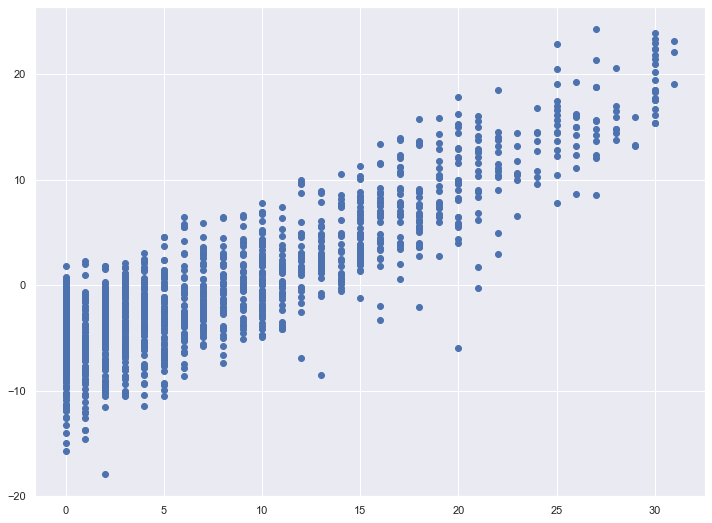

In [409]:
y_train_pred = lr_rfe.predict(X_train_subset_scaled)
residuals = y_train-y_train_pred
fig, ax = plt.subplots(figsize = (12,9))
plt.scatter(y_train, residuals)

One byproduct of linear regression is that it can predict negative values even when such a prediction does not make real-world sense. In fact, some schools with 0 violent incidents were predicted as having negative incidents. As a final adjustment to the OLS with RFE model, I adjusted any negative predictions to output 0 instead. Below is a cross-validated simulation of the model. Given that only a few predictions were negative, this final model only gives marginal improvement.

In [410]:
from sklearn.metrics import mean_squared_error
cvs_final_model = []
for train_index, cv_index in kf.split(X_train_subset_scaled):
    x_train_temp, x_cv = X_train_subset_scaled.iloc[train_index], X_train_subset_scaled.iloc[cv_index]
    y_train_temp, y_cv = y_train.iloc[train_index], y_train.iloc[cv_index]
    lr_rfe.fit(x_train_temp,y_train_temp)
    y_pred = lr_rfe.predict(x_cv)
    #Adjust negative predictions to 0
    y_pred = [y if y>0 else 0 for y in y_pred]
    rmse = mean_squared_error(y_cv, y_pred)**.5
    cvs_final_model.append(rmse)
np.mean(cvs_final_model)

7.022960908337237

Finally, for an unbiased estimate of how this model would perform on unseen data, I fit it on the whole training set (ignoring CV folds) and calculated a final RMSE value for the test set.

In [474]:
lr_rfe.fit(X_train_subset_scaled, y_train)
y_pred = lr_rfe.predict(X_test_subset_scaled)
y_pred = [y if y>0 else 0 for y in y_pred]
rmse = mean_squared_error(y_test, y_pred)**.5
rmse

7.822365366897361

## 4. Conclusion/Further Steps

While the OLS RFE model did show some modest promise in making predictions about violent incidents, it can clearly be improved. The RMSE of 7.82 on the test set is quite high given that the range of violent incidents for the schools studied was 0 to 31. However, the statistical significance of the model features suggests that these inputs are useful.

As a first additional step, I would focus on reducing model bias and bringing the k-fold RMSE value down to a more reasonable number. This can be accomplished in a variety of ways:
1. Introduce interaction/polynomial features
2. Get additional data on the schools in this survey
    1. Precise number of students in each school
    2. More granular demographic information (ethnicity, religion, political)
    3. Geographical location (state, city, etc.)
3. Get additional data about the area surrounding the school
    1. Weapon laws/sales
    2. Precise crime rate
 
Unfortunately, this survey anonymized responses, so it isn't currently possible to gather additional data corresponding to an individual school. However, the SSOCS has also been conducted during several other years in the past, and it would be interesting to see how the temporal component affects violent incidents and whether any trends have appeared over time.